In [1]:
"""
Analyze X-A push beam in-cell absorption data to confirm resonance frequency
and look for N=1 hyperfine structure.
"""

import h5py
import os
import numpy as np


#from entire hdf5 data file, initialize run names we care about
absolute_path = os.path.abspath('')
rel_path = "log_2024Feb19.hdf" # in cell absorption data for push beam
filename = os.path.join(absolute_path, rel_path)
run_names = ['run17:10:54', 'run17:18:36', 'run17:24:41', 'run17:29:53'] #run names we care about (first two EOM on ,second two EOM off)

#open file and process data
with h5py.File(filename, 'r') as hdf:
    #dict1 is reduced dict of {run names : run data} only for runs we care about
    dict1 = {key: hdf[key] for key in run_names if key in hdf} 
    runs = [None for _ in range(len(run_names))]
    for key in dict1:
        run = dict1[key]
        num_images = len(run)
        sorted_keys = sorted(run.keys(), key=int) #sort run keys by true numerical order (not "string numerical" order")
        
        #run_shot is a list of the shots in each run in true numerical order. each shot is one absorption trace.
        run_shot = [None for _ in range(num_images)]
        for key2 in sorted_keys:
            run_shot[int(key2)] = run[key2] 

        #extract data from runs (make list of lists of times and pd_voltages)
        layers, rows, cols = num_images, 2, 500
        run_data = [[[None for _ in range(cols)] for _ in range(rows)] for _ in range(layers)]

        for i in range(num_images):
            times, pd_voltages = zip(*run_shot[i])
            run_data[i][0] = np.asarray(times)
            run_data[i][1] = np.asarray(pd_voltages)
        
        runs[run_names.index(key)] = run_data 

    #dict2 is dict of {run names : runs} where runs is a list of 3D list containing all data for each shot (trace time and PD voltage)
    dict2 = {key: runs for key in run_names} 

In [2]:
#go through dict2, analyze data, and extract absorption spectroscopy curves
#the val of dict2 (runs) is a 3D list in the form [shot number][time or voltage][value]
from matplotlib import axis
import matplotlib.pyplot as plt

#based on timing of push beam, the absorption dip should always be between 2 and 10 ms.
#furthermore, the most relevant data is in the first 20 ms (when slowing occurs)
#our signal will be the difference between the minimum value in the first 10 ms, and the average in the first 20 ms excluding t = 2 to t = 10 ms

rows, cols = 2, len(run_names)
absorption = [[None for _ in range(cols)] for _ in range(rows)]

for i in range(len(run_names)):
    run = runs[i]
    num_images = len(run)
    if i == 0 or i == 3:
        freqs = np.linspace(0, 400, num_images)
    else:
        freqs = np.linspace(0, -400, num_images)

    sig = np.empty(num_images)
    for j in range(num_images):
        times, pd_voltages = run[j]
        min_index = np.where(times == 2)[0][0]
        max_index = np.where(times == 10)[0][0]
        max_index2 = np.where(times == 20)[0][0]
        min_value = np.min(pd_voltages[min_index:max_index])
        avg_value = np.mean(pd_voltages[:min_index])
        signal = min_value - avg_value
        sig[j] = signal
    absorption[0][i] = freqs
    absorption[1][i] = sig

#dict3 is dict of {run names : absorption data} where absorption data is a list of lists containing frequency and absorption signal
dict3 = {key: absorption for key in run_names} 

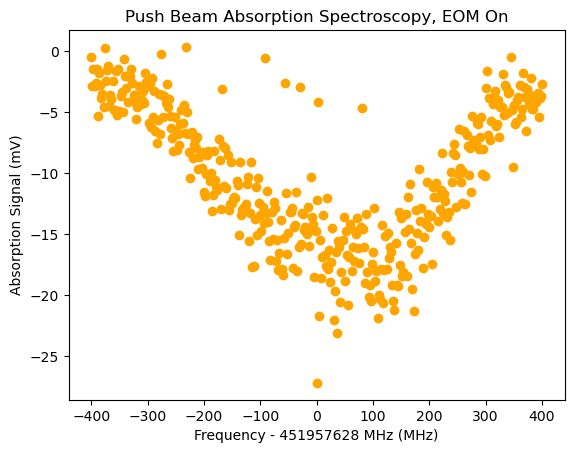

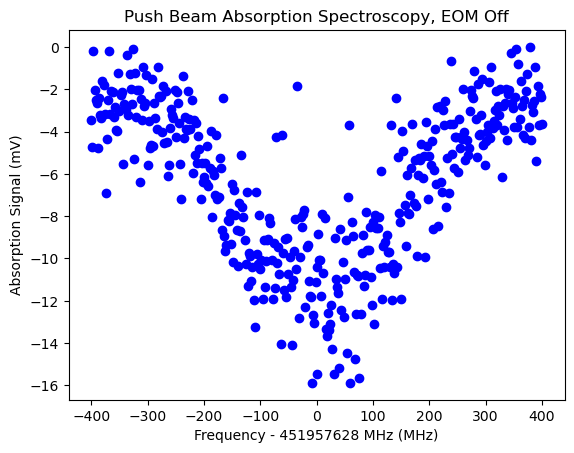

In [3]:
#finally, stitch together runs 0 and 1, and runs 2 and 3, to get the full absorption spectrum
for key_index, key in enumerate(dict3):
    if key_index == 1 or key_index == 2:
        absorption[0][key_index] = np.flip(absorption[0][key_index])
        absorption[1][key_index] = np.flip(absorption[1][key_index])

freq1 = np.concatenate((absorption[0][1], absorption[0][0]))
sig1 = np.concatenate((absorption[1][1], absorption[1][0]))*1e3
freq2 = np.concatenate((absorption[0][2], absorption[0][3]))
sig2 = np.concatenate((absorption[1][2], absorption[1][3]))*1e3


plt.plot(freq1, sig1, 'o', color='orange')
plt.xlabel("Frequency - 451957628 MHz (MHz)")
plt.ylabel("Absorption Signal (mV)")
plt.title("Push Beam Absorption Spectroscopy, EOM On")
plt.show()

plt.plot(freq2, sig2, 'o', color='blue')
plt.xlabel("Frequency - 451957628 MHz (MHz)")
plt.ylabel("Absorption Signal (mV)")
plt.title("Push Beam Absorption Spectroscopy, EOM Off")
plt.show()    